# Lab 04 for the course Machine Learning
###### Student: Hristijan Stojchevski 161278

In [1]:
from pylab import rcParams
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import operator

from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.utils.multiclass import type_of_target
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet

from collections import Counter
import warnings
scaler = MinMaxScaler()
warnings.filterwarnings('ignore')

## REGRESSION PROBLEM

### Forest fires dataset

In [2]:
model_results = {}

forest_data = pd.read_csv("../data/forest-fires/forestfires.csv")
print(forest_data)
X = forest_data.iloc[:,:-1]
X = X.to_numpy(dtype=np.object,copy=True, na_value=0)
y = forest_data.iloc[:,-1]
y = y.to_numpy(copy=True)
months = np.unique(X[:,2])
days = np.unique(X[:,3])
X = X.T
for i, c in zip(range(0, 12), months):
    X[2, X[2] == c] = i
for i, c in zip(range(0, 7), days):
    X[3, X[3] == c] = i
X = X.T
X = scaler.fit_transform(X)
print(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]
[[0.75       0.42857143 0.63636364 ... 0.42352941 0.7        0.

### Visualization
- From the correlation matrix we can see that features 0,1,4,5,6,7,8 are highly corelated.
 But this is strange, because the correlation between month and temperature is low.

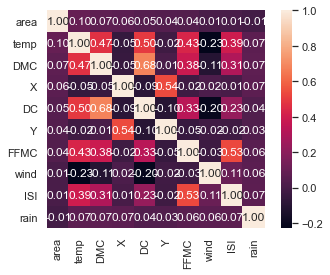

In [3]:
correlation = forest_data.corr(method='pearson')
columns = correlation.nlargest(10, 'area').index
correlation_map = np.corrcoef(forest_data[columns].values.T)
sb.set(font_scale=1.0)
heatmap = sb.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

12


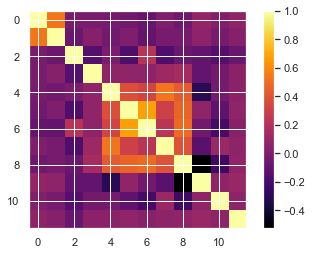

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain'],
      dtype='object')


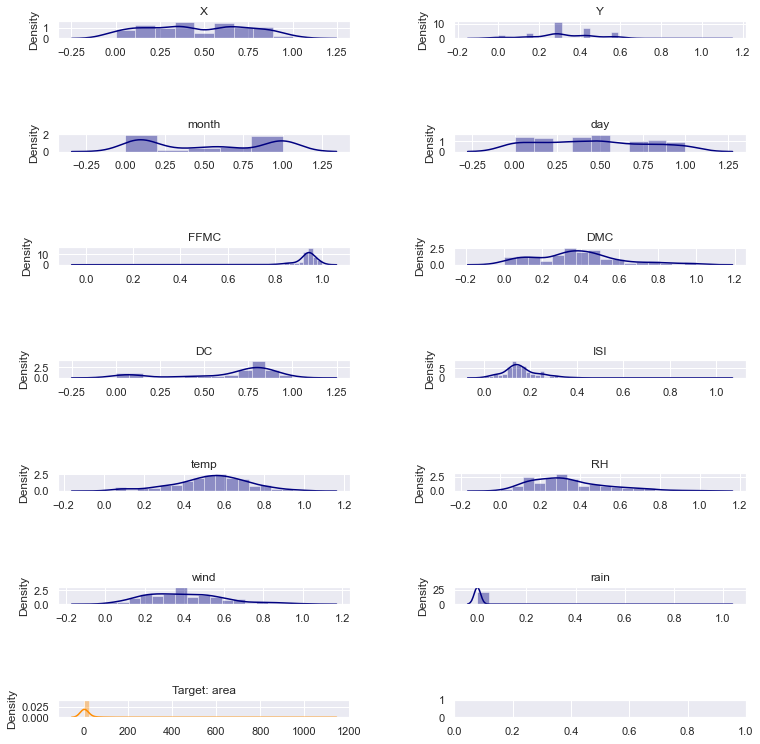

In [4]:
num_features = len(X[0])
print(num_features)
correlation_matrix = np.zeros((num_features,num_features))
for i in range(num_features): #We need a 8x8 matrix to represent the correlation matrix, where we set the value of Cij to be the correlation between the i'th and the j'th metric
    measure = X[:,i]
    for j in range(num_features):
        measure2 = X[:,j]
        corr, _ = stats.pearsonr(measure, measure2)
        correlation_matrix[i][j] = corr
plt.figure()
plt.imshow(correlation_matrix, cmap = "inferno") #We can draw the matrix using imshow
plt.colorbar()
plt.show()

# Feature plot
feature_names = forest_data.iloc[:,:-1].columns
print(feature_names)
fig = plt.figure(figsize=(12, 12))
fig.subplots(num_features//2+1, ncols=2)
fig.tight_layout(pad=6)
for feat_i in range(num_features): #The histograms of the features
    ax = plt.subplot(num_features//2+1,2, feat_i+1)
    plt.title(feature_names[feat_i])
    sb.distplot(X[:,feat_i], color = "navy")
ax = plt.subplot(num_features//2+1,2, feat_i+2)
plt.title("Target: area")
sb.distplot(y, color = "darkorange") #The histograms of the target variable
plt.show()

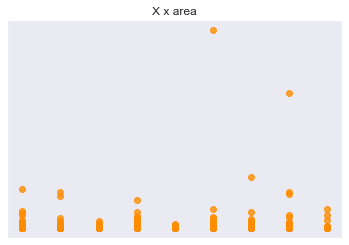

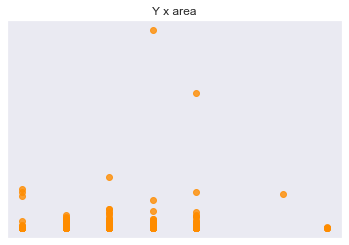

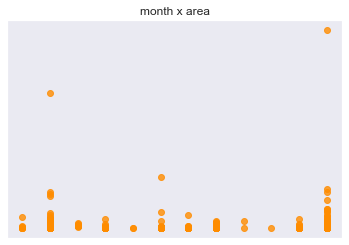

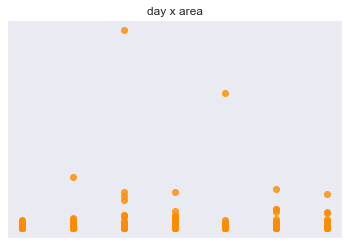

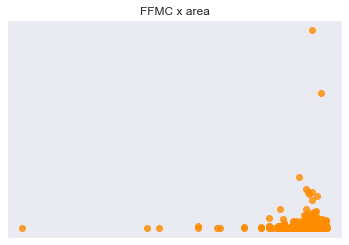

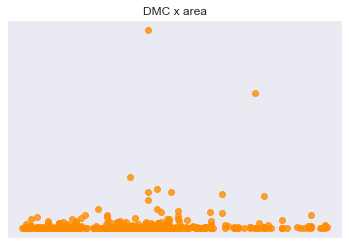

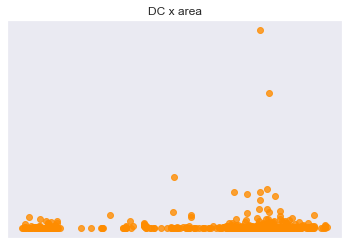

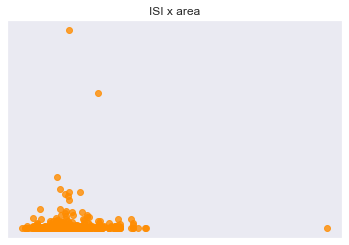

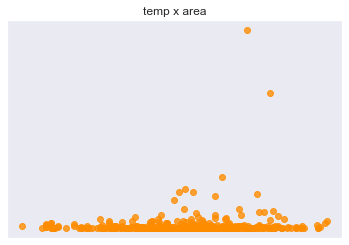

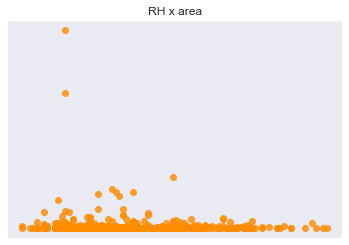

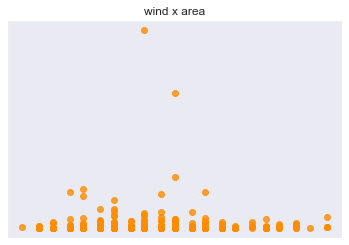

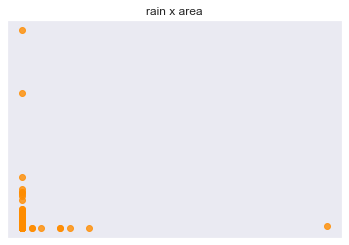

In [5]:
for feat_i in range(num_features):
    plt.figure()
    plt.scatter( X[:, feat_i], y,  alpha=.8, color="darkorange")
    plt.xticks(())
    plt.yticks(())
    ax.axis('equal')
    plt.title(feature_names[feat_i] + " x " + forest_data.columns[-1])
    plt.show()

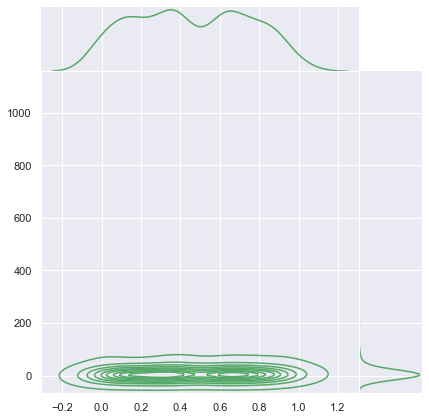

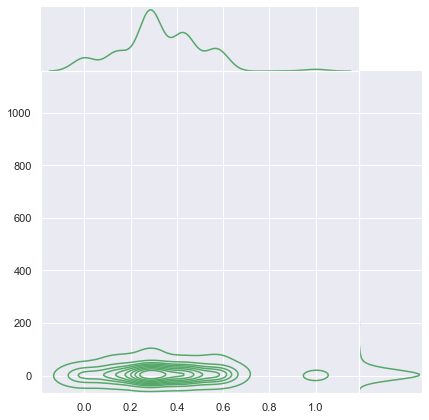

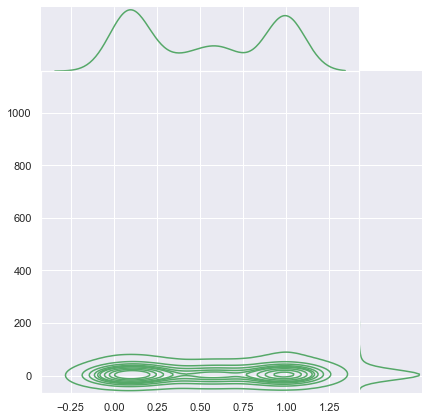

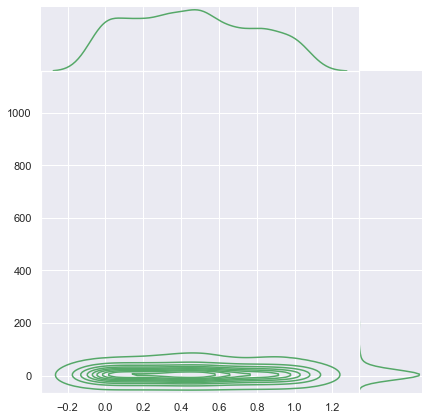

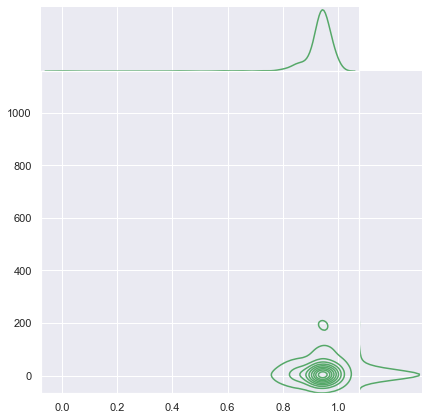

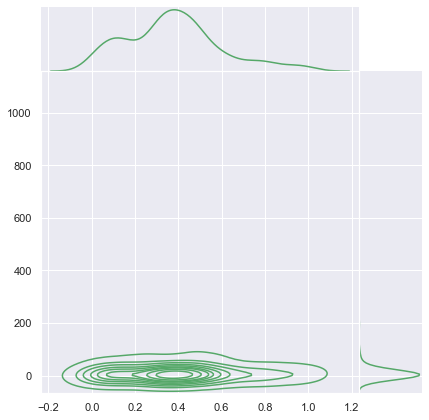

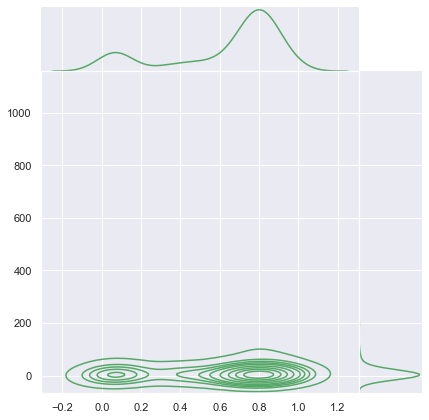

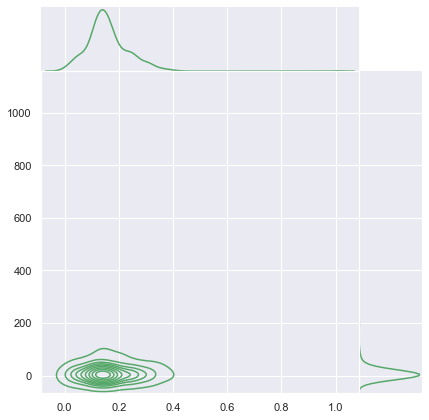

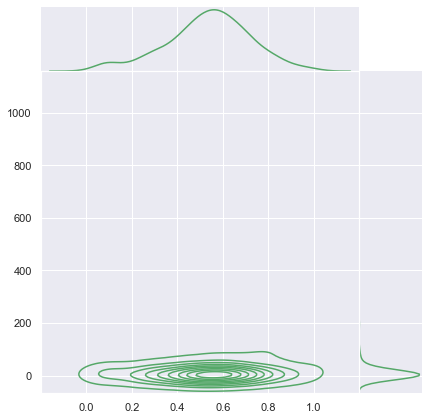

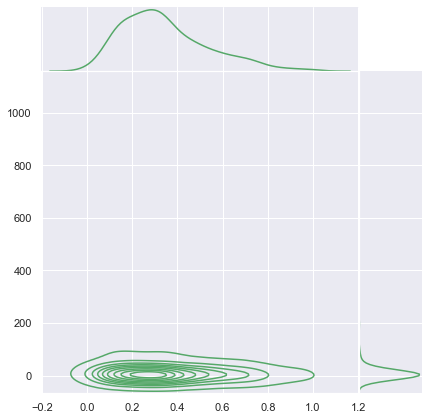

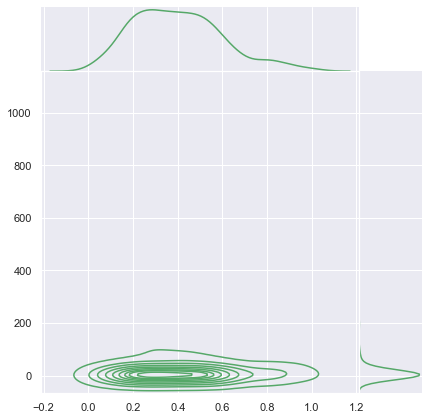

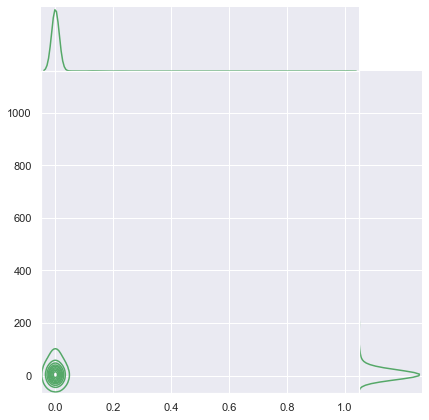

In [6]:
for feat_i in range(num_features):
    sb.jointplot(X[:, feat_i], y, kind="kde", space=0, color="g")
plt.show()

In [7]:
# feature selection
def select_features(X_tr, y_tr, X_te, regressor=f_regression, keep='all'):
	# configure to select all features
	fs = SelectKBest(score_func=regressor, k=keep)
	# learn relationship from training data
	fs.fit(X_tr, y_tr)
	# transform train input data
	X_train_fs = fs.transform(X_tr)
	# transform test input data
	X_test_fs = fs.transform(X_te)
	return X_train_fs, X_test_fs, fs

## Feature selection and extraction

In [8]:
# X_train_fs2, X_test_fs2, fs2 = select_features(X_train,y_train, X_test, mutual_info_regression, 9)
# for i in range(len(fs2.scores_)):
# 	print('Feature %d: %f' % (i, fs2.scores_[i]))
# # plot the scores
# plt.bar([i for i in range(len(fs2.scores_))], fs2.scores_)
# plt.show()
# print(len(X_train_fs2[0]))

Best MAE: -4047.498
Best Config: {'sel__k': 5}
>-4058.981 with: {'sel__k': 2}
>-4059.505 with: {'sel__k': 3}
>-4057.386 with: {'sel__k': 4}
>-4047.498 with: {'sel__k': 5}
>-4050.467 with: {'sel__k': 6}
>-4054.848 with: {'sel__k': 7}
>-4048.575 with: {'sel__k': 8}
>-4048.820 with: {'sel__k': 9}
>-4052.861 with: {'sel__k': 10}
>-4061.321 with: {'sel__k': 11}
>-4059.206 with: {'sel__k': 12}
Means [-4058.98081383 -4059.50540133 -4057.38574314 -4047.49798809
 -4050.46669311 -4054.84820778 -4048.57456535 -4048.81985356
 -4052.86124822 -4061.32078199 -4059.20562554]
Params [{'sel__k': 2}, {'sel__k': 3}, {'sel__k': 4}, {'sel__k': 5}, {'sel__k': 6}, {'sel__k': 7}, {'sel__k': 8}, {'sel__k': 9}, {'sel__k': 10}, {'sel__k': 11}, {'sel__k': 12}]
Best MAE: -4045.219
Best Config: {'sel__k': 6}
>-4049.244 with: {'sel__k': 2}
>-4061.172 with: {'sel__k': 3}
>-4050.723 with: {'sel__k': 4}
>-4049.745 with: {'sel__k': 5}
>-4045.219 with: {'sel__k': 6}
>-4051.498 with: {'sel__k': 7}
>-4059.122 with: {'sel__k

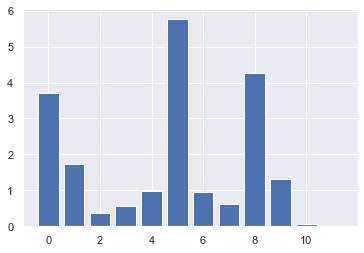

6
MSE: 9436.336
RMSE: 97.141
MAE: 21.947
Custom chosen parameters
MSE: 9437.015
RMSE: 97.144
MAE: 21.886


In [9]:
reg_res = { 'MSE': 0, 'RMSE': 0, 'MAE': 0}
# define the evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(2, 13)]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))
max_mean = results.best_score_
num_keep = results.best_params_['sel__k']

print("Means", means)
print("Params", params)

# define the pipeline to evaluate
model = LinearRegression()
fs = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
# define the grid
grid = dict()
grid['sel__k'] = [i for i in range(2, 13)]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best MAE: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
for mean, param in zip(results.cv_results_['mean_test_score'], results.cv_results_['params']):
    print(">%.3f with: %r" % (mean, param))
if results.best_score_ > max_mean:
    num_keep = results.best_params_['sel__k']
    max_mean = results.best_score_
    X_train_fs1, X_test_fs1, fs1 = select_features(X_train,y_train, X_test, f_regression, num_keep)
    for i in range(len(fs1.scores_)):
        print('Feature %d: %f' % (i, fs1.scores_[i]))
    # plot the scores
    plt.bar([i for i in range(len(fs1.scores_))], fs1.scores_)
    plt.show()
    print(len(X_train_fs1[0]))
    model = LinearRegression()
    model.fit(X_train_fs1, y_train)
    # evaluate the model
    y_pred = model.predict(X_test_fs1)
    # evaluate predictions
    mse = sm.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = sm.mean_absolute_error(y_test, y_pred)
    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % rmse)
    print('MAE: %.3f' % mae)

    reg_res['MSE'] = mse
    reg_res['RMSE'] = rmse
    reg_res['MAE'] = mae
else:
    X_train_fs1, X_test_fs1, fs1 = select_features(X_train,y_train, X_test, f_regression, num_keep)
    for i in range(len(fs1.scores_)):
        print('Feature %d: %f' % (i, fs1.scores_[i]))
    # plot the scores
    plt.bar([i for i in range(len(fs1.scores_))], fs1.scores_)
    plt.show()
    print(len(X_train_fs1[0]))
    model = LinearRegression()
    model.fit(X_train_fs1, y_train)
    # evaluate the model
    y_pred = model.predict(X_test_fs1)
    # evaluate predictions
    mse = sm.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = sm.mean_absolute_error(y_test, y_pred)
    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % rmse)
    print('MAE: %.3f' % mae)

    reg_res['MSE'] = mse
    reg_res['RMSE'] = rmse
    reg_res['MAE'] = mae

custom_X_train = np.vstack((X_train.T[0:3], X_train.T[5:10], X_train.T[11]))
custom_X_train = custom_X_train.T
custom_X_test = np.vstack((X_test.T[0:3], X_test.T[5:10], X_test.T[11]))
custom_X_test = custom_X_test.T
model = LinearRegression()
model.fit(custom_X_train, y_train)
# evaluate the model
y_pred = model.predict(custom_X_test)
# evaluate predictions
mse = sm.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = sm.mean_absolute_error(y_test, y_pred)
print("Custom chosen parameters")
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

if mse < reg_res['MSE']:
    reg_res['MSE'] = mse
    reg_res['RMSE'] = rmse
    reg_res['MAE'] = mae

model_results['LRE'] = reg_res

### Pipelining multiple regression models to find the best one.

In [10]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines.append(('ScaledBAYESR', Pipeline([('Scaler', StandardScaler()),('BR', BayesianRidge())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('ScaledNN', Pipeline([('Scaler', StandardScaler()),('NN', MLPRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = RepeatedKFold(n_splits=10,n_repeats=3, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -2330.975712 (4157.286005)
ScaledLASSO: -2251.536319 (4204.435454)
ScaledEN: -2242.702231 (4212.227769)
ScaledKNN: -2633.513667 (4016.897771)
ScaledCART: -6779.900416 (6973.748100)
ScaledGBM: -4290.419680 (4612.398807)
ScaledRIDGE: -2329.964906 (4157.834465)
ScaledBAYESR: -2236.710519 (4257.237878)
ScaledSVR: -2328.824666 (4383.014176)
ScaledNN: -2260.454901 (4145.435837)


### Od prethodnoto testiranje moze da zakluchime deka edni od podobrite modeli se BayesianRidge i nevronska mreza

In [11]:
# Set the parameters by cross-validation CV
param_list = {"hidden_layer_sizes": [(9,),(50,),(100,0),(500,0),(1000,0),(4,2),(8,2),(20,2)],
              "activation": ["tanh", "relu"],
              "solver": ["sgd", "adam"],
              "alpha": [0.0001, 0.00005,0.001, 0.005, 0.01, 0.05],
              "learning_rate_init": [0.00001, 0.001, 0.01, 0.1]
              }
MLPRegressor()

clf = GridSearchCV(MLPRegressor(), param_list, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print("Best parameters for forest fires NN are:", clf.best_params_)
print("Report for development parameters:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
y1_true, y1_pred = y_test, clf.predict(X_test)

Best parameters for forest fires NN are: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (4, 2), 'learning_rate_init': 0.001, 'solver': 'sgd'}
Report for development parameters:
-2304.426 (+/-5739.557) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (9,), 'learning_rate_init': 1e-05, 'solver': 'sgd'}
-2354.157 (+/-5803.513) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (9,), 'learning_rate_init': 1e-05, 'solver': 'adam'}
-2208.390 (+/-5492.636) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (9,), 'learning_rate_init': 0.001, 'solver': 'sgd'}
-2252.687 (+/-5692.654) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (9,), 'learning_rate_init': 0.001, 'solver': 'adam'}
-2294.307 (+/-5420.129) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (9,), 'learning_rate_init': 0.01, 'solver': 'sgd'}
-2209.413 (+/-5535.170) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (9,), 'l

In [4]:
reg_res = { 'MSE': 0, 'RMSE': 0, 'MAE': 0}
mlp = MLPRegressor(hidden_layer_sizes=(4,2), activation='relu', solver='sgd', alpha=0.005, learning_rate_init=0.001)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
mse_mlp = sm.mean_squared_error(y_test, y_pred)
rmse_mlp = np.sqrt(mse_mlp)
mae_mlp = sm.mean_absolute_error(y_test, y_pred)
print("MLPRegressor score:")
print('MSE: %.3f' % mse_mlp)
print('RMSE: %.3f' % rmse_mlp)
print('MAE: %.3f' % mae_mlp)
reg_res['MSE'] = mse_mlp
reg_res['RMSE'] = rmse_mlp
reg_res['MAE'] = mae_mlp
model_results['MLPReg'] = reg_res

MLPRegressor score:
MSE: 9481.132
RMSE: 97.371
MAE: 20.917


In [13]:
# Set the parameters by cross-validation CV
param_list = {"n_iter": [50, 100, 300, 500],
              "normalize": [False, True]
              }

# letters 1
clf_let = GridSearchCV(BayesianRidge(), param_list, scoring='neg_mean_squared_error')
clf_let.fit(X_train, y_train)
print("Best parameters for forest fires NN are:", clf_let.best_params_)
print("Report for development parameters:")
means = clf_let.cv_results_['mean_test_score']
stds = clf_let.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_let.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
y1_true, y1_pred = y_test, clf_let.predict(X_test)

Best parameters for forest fires NN are: {'n_iter': 100, 'normalize': False}
Report for development parameters:
-2217.277 (+/-5583.648) for {'n_iter': 50, 'normalize': False}
-2224.291 (+/-5588.400) for {'n_iter': 50, 'normalize': True}
-2217.277 (+/-5583.649) for {'n_iter': 100, 'normalize': False}
-2224.049 (+/-5587.456) for {'n_iter': 100, 'normalize': True}
-2217.277 (+/-5583.649) for {'n_iter': 300, 'normalize': False}
-2224.049 (+/-5587.456) for {'n_iter': 300, 'normalize': True}
-2217.277 (+/-5583.649) for {'n_iter': 500, 'normalize': False}
-2224.049 (+/-5587.456) for {'n_iter': 500, 'normalize': True}


In [7]:
reg_res = { 'MSE': 0, 'RMSE': 0, 'MAE': 0}
bRidge = BayesianRidge(n_iter=100)
bRidge.fit(X_train, y_train)
y_pred = bRidge.predict(X_test)
mse_bay = sm.mean_squared_error(y_test, y_pred)
rmse_bay = np.sqrt(mse_bay)
mae_bay = sm.mean_absolute_error(y_test, y_pred)
print("Bayesian Ridge score:")
print('MSE: %.3f' % mse_bay)
print('RMSE: %.3f' % rmse_bay)
print('MAE: %.3f' % mae_bay)
reg_res['MSE'] = mse_bay
reg_res['RMSE'] = rmse_bay
reg_res['MAE'] = mae_bay
model_results['BayRidge'] = reg_res

Bayesian Ridge score:
MSE: 9478.902
RMSE: 97.360
MAE: 21.251


##### Best model is the one with the lowest MSE

In [8]:
best_model = {}
min_mse = 10000000
for name, scores in model_results.items():
    if min_mse > scores['MSE']:
        min_mse = scores['MSE']
        best_model = model_results[name]
        best_model['name'] = name
while min_mse == 1000:
    pass
print(best_model['name'], "is the best model for predicting this dataset and the scores are:")
print("MSE:", best_model['MSE'])
print("RMSE", best_model['RMSE'])
print("MAE", best_model['MAE'])

BayRidge is the best model for predicting this dataset and the scores are:
MSE: 9478.902444946054
RMSE 97.35965511928467
MAE 21.251059526677384


 - note that if we look at MAE score then the best model is the neural network

# Letter recognition dataset

## Letter recognition data proccesing and no need for extra Normalization, the dataset was already Normalized to integer values 0-15

6666
[19 8 3 ... 19 18 0]
[[-3.52375517  5.78413657 -2.60068651]
 [ 3.06158222 -3.81072757 -3.43591987]
 [ 5.00007259 -3.18656547 -3.86934939]
 ...
 [-8.45139213 -2.10765496  2.16764498]
 [-8.11501899 -0.79143972 -5.13855818]
 [ 7.94589325 -1.07191335  2.34825581]]


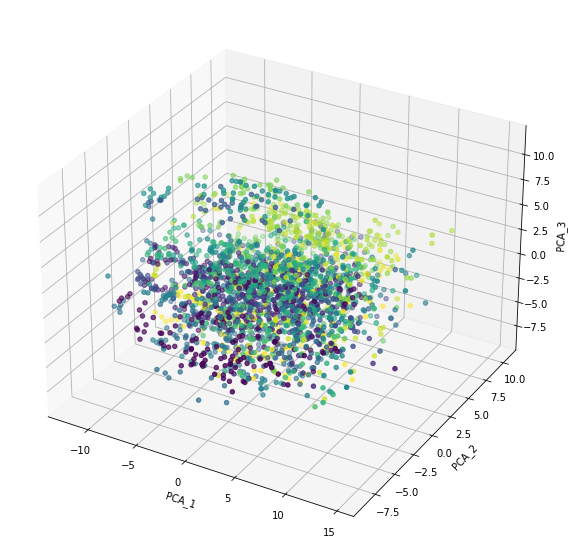

In [10]:
dataLettersFull = np.loadtxt(open('../Datasets/letter-recognition.data'),delimiter=',',dtype=np.object)
dataLetters = dataLettersFull[:,1:].astype(np.int)
dataLetters_class = dataLettersFull[:,0].astype(np.str)
let_train, let_test, letY_train, letY_test = train_test_split(dataLetters,dataLetters_class, test_size=0.3333, random_state=42)
print(len(let_test))

target = dataLetters_class.copy()
unique_class = np.unique(target)
target = target.astype(np.object)
for i, c in zip(range(0,len(unique_class)), unique_class):
    target[target == c] = i
print(target)
pca_3D = PCA(n_components=3)
pca_3D.fit(dataLetters[:2500])
pca_t3 = pca_3D.fit_transform(dataLetters[:2500])
pca_t3 = np.ascontiguousarray(pca_t3)


fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_t3[:,0],pca_t3[:,1],pca_t3[:,2],c=target[:2500])
ax.set_xlabel('PCA_1')
ax.set_ylabel("PCA_2")
ax.set_zlabel("PCA_3")
print(pca_t3)
plt.show()

## Classification on letter dataset
- Data is seperated into 1/3 for validation and 2/3 for training the models
- From the results below we can see that the best NN models are the ones with 100 and 700 neurons in the hidden layer

letters_MLP1 = MLPClassifier((6,),learning_rate_init=0.01)
letters_MLP2 = MLPClassifier((100,),learning_rate_init=0.01)
letters_MLP3 = MLPClassifier((700,),learning_rate_init=0.01)
letters_MLP4 = MLPClassifier((2,2),learning_rate_init=0.01)
letters_MLP5 = MLPClassifier((4,2),learning_rate_init=0.01)
# 50 in hidden LR = 0.01, test size = 0.5*N
letters_MLP1.fit(let_train,letY_train)
predictions_let = letters_MLP1.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN1 is :",acc/n_test)
letters_MLP2.fit(let_train,letY_train)
predictions_let = letters_MLP2.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN2 is :",acc/n_test)
letters_MLP3.fit(let_train,letY_train)
# predictions_let = letters_MLP3.predict(let_test)
# N = len(dataLetters)//
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN3 is :",acc/n_test)
letters_MLP4.fit(let_train,letY_train)
predictions_let = letters_MLP4.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN4 is :",acc/n_test)
letters_MLP5.fit(let_train,letY_train)
predictions_let = letters_MLP5.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN5 is :",acc/n_test)

In [17]:
letters_MLP1 = MLPClassifier((6,),learning_rate_init=0.01)
letters_MLP2 = MLPClassifier((100,),learning_rate_init=0.01)
letters_MLP3 = MLPClassifier((700,),learning_rate_init=0.01)
letters_MLP4 = MLPClassifier((2,2),learning_rate_init=0.01)
letters_MLP5 = MLPClassifier((4,2),learning_rate_init=0.01)
# 50 in hidden LR = 0.01, test size = 0.5*N
letters_MLP1.fit(let_train,letY_train)
predictions_let = letters_MLP1.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN1 is :",acc/n_test)
letters_MLP2.fit(let_train,letY_train)
predictions_let = letters_MLP2.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN2 is :",acc/n_test)
letters_MLP3.fit(let_train,letY_train)
# predictions_let = letters_MLP3.predict(let_test)
# N = len(dataLetters)//
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN3 is :",acc/n_test)
letters_MLP4.fit(let_train,letY_train)
predictions_let = letters_MLP4.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN4 is :",acc/n_test)
letters_MLP5.fit(let_train,letY_train)
predictions_let = letters_MLP5.predict(let_test)
N = len(dataLetters)
n_test = len(let_test)
acc = 0
for pred, ver in zip(predictions_let, letY_test):
    if pred == ver:
       acc += 1
print("Acurr of letters dataset NN5 is :",acc/n_test)

Acurr of letters dataset NN1 is : 0.6345634563456346
Acurr of letters dataset NN2 is : 0.9243924392439244
Acurr of letters dataset NN3 is : 0.9243924392439244
Acurr of letters dataset NN4 is : 0.16876687668766877
Acurr of letters dataset NN5 is : 0.3235823582358236


## SVM For Letters

- As the best SVM model is choosen the one with gaussian kernel and parameters C = 1000 and gamma = 0.001

In [12]:
# Set the parameters by cross-validation CV
tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma': [0.001,1e-3, 1e-4],'C': [1, 10, 100, 1000]}]
# letters 1
clf_let = GridSearchCV(SVC(), tuned_parameters, scoring='precision_macro') #  5-fold CV on 2/3 of data
clf_let.fit(let_train, letY_train)
print("Best parameters for letters:", clf_let.best_params_)
print("Report for development parameters:")
means = clf_let.cv_results_['mean_test_score']
stds = clf_let.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_let.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
y1_true, y1_pred = letY_test, clf_let.predict(let_test)

Best parameters for letters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Report for development parameters:
0.851 (+/-0.002) for {'C': 1, 'kernel': 'linear'}
0.848 (+/-0.007) for {'C': 10, 'kernel': 'linear'}
0.847 (+/-0.009) for {'C': 100, 'kernel': 'linear'}
0.847 (+/-0.008) for {'C': 1000, 'kernel': 'linear'}
0.813 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.813 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.635 (+/-0.022) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.883 (+/-0.011) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.883 (+/-0.011) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.800 (+/-0.012) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.923 (+/-0.007) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.923 (+/-0.007) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.849 (+/-0.008) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.944 (+/-0.006) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.944 (+/-0.006) for {'C': 1000, 'gamma'

## SVM report

### The best SVM model has proven to be 96% precise which makes the best model for this datasets

In [13]:
"""
    Tuka imame rezultati od test klasifikacijata so 1/3 od data
    So precision pokazuvame br na True Positives za sekoja od klasite nasproti vk broj na pozitivni tp / (tp + fp)
"""
print("Classification report for letters:")
print(classification_report(y1_true, y1_pred))

Classification report for letters:
              precision    recall  f1-score   support

           A       0.98      0.99      0.98       266
           B       0.92      0.95      0.94       256
           C       0.91      0.91      0.91       214
           D       0.91      0.96      0.94       284
           E       0.94      0.95      0.94       261
           F       0.92      0.98      0.95       235
           G       0.92      0.94      0.93       247
           H       0.94      0.84      0.89       241
           I       0.96      0.96      0.96       244
           J       0.97      0.94      0.95       248
           K       0.91      0.94      0.92       204
           L       0.98      0.95      0.96       249
           M       0.99      0.96      0.97       276
           N       0.97      0.94      0.95       262
           O       0.94      0.93      0.94       251
           P       0.99      0.96      0.97       280
           Q       0.96      0.96      0.96   